📈 Correlation between Quantity and UnitPrice: -0.0209


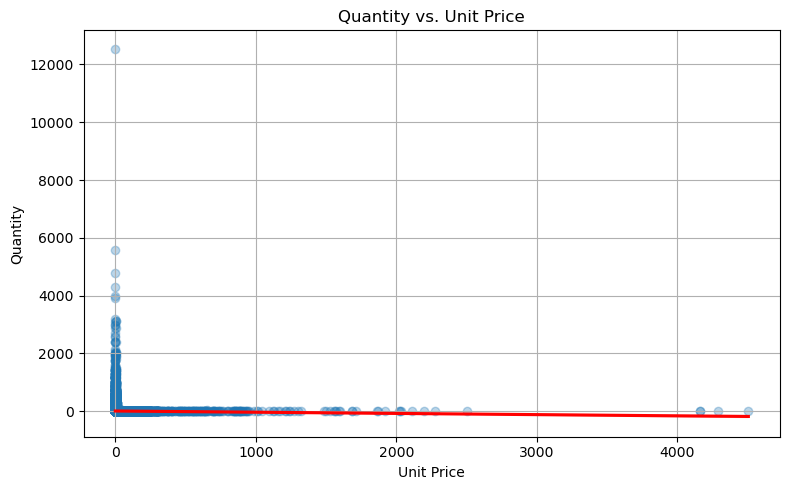

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the cleaned dataset
df = pd.read_excel("../data/cleaned_retail.xlsx", engine="openpyxl")

# Optional: filter out Cancellations
df_filtered = df[df['CancellationFlag'].isnull() | (df['CancellationFlag'].astype(str).str.strip() == '')]


# Compute correlation
correlation = df_filtered['Quantity'].corr(df_filtered['UnitPrice'])
print(f"Correlation between Quantity and UnitPrice: {correlation:.4f}")

# Visualize with scatter plot + regression line
plt.figure(figsize=(8, 5))
sns.regplot(data=df_filtered, x='UnitPrice', y='Quantity', scatter_kws={'alpha':0.3}, line_kws={'color':'red'})
plt.title('Quantity vs. Unit Price')
plt.xlabel('Unit Price')
plt.ylabel('Quantity')
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd
from datetime import timedelta

# Load cleaned retail data
df = pd.read_excel("../data/cleaned_retail.xlsx", engine="openpyxl")

# Filter out cancelled transactions
df_clean = df[df['CancellationFlag'].isnull() | (df['CancellationFlag'].astype(str).str.strip() == '')]

# Create TotalPrice column
df_clean['TotalPrice'] = df_clean['Quantity'] * df_clean['UnitPrice']

# Define reference date (day after last transaction)
reference_date = df_clean['InvoiceDate'].max() + timedelta(days=1)

# RFM aggregation
rfm = df_clean.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (reference_date - x.max()).days,  # Recency
    'InvoiceNo': 'nunique',                                     # Frequency
    'TotalPrice': 'sum'                                         # Monetary
}).reset_index()

# Rename columns
rfm.columns = ['CustomerID', 'Recency', 'Frequency', 'Monetary']

# RFM scoring (1–5 scale)
rfm['R_score'] = pd.qcut(rfm['Recency'], 5, labels=[5,4,3,2,1])
rfm['F_score'] = pd.qcut(rfm['Frequency'].rank(method='first'), 5, labels=[1,2,3,4,5])
rfm['M_score'] = pd.qcut(rfm['Monetary'], 5, labels=[1,2,3,4,5])

# Combine scores into a single string
rfm['RFM_score'] = rfm['R_score'].astype(str) + rfm['F_score'].astype(str) + rfm['M_score'].astype(str)

# Define interpretation logic
def interpret_rfm(row):
    r, f, m = int(row['R_score']), int(row['F_score']), int(row['M_score'])
    if r == 5 and f == 5 and m == 5:
        return " Best customer: recent, frequent, high spender"
    elif r >= 4 and f >= 4 and m >= 4:
        return " Loyal and valuable"
    elif r <= 2 and f <= 2 and m <= 2:
        return " At risk or churned"
    elif m >= 4 and f <= 2:
        return " High spender, but infrequent"
    elif r >= 4 and f <= 2:
        return " Recent but infrequent"
    else:
        return " Mid-tier customer"

# Apply interpretation
rfm['Interpretation'] = rfm.apply(interpret_rfm, axis=1)

# Preview
print("RFM table with interpretation:")
print(rfm[['CustomerID', 'Recency', 'Frequency', 'Monetary', 'RFM_score', 'Interpretation']].head())

C:\Users\lmcr-\AppData\Local\Temp\ipykernel_1700\3138983537.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['TotalPrice'] = df_clean['Quantity'] * df_clean['UnitPrice']


✅ RFM table with interpretation:
  CustomerID  Recency  Frequency  Monetary RFM_score  \
0      12347        2          7   4310.00       555   
1      12348       75          4   1797.24       244   
2      12349       19          1   1757.55       414   
3      12350      310          1    334.40       112   
4      12352       36          7   2385.71       355   

                                    Interpretation  
0  🟢 Best customer: recent, frequent, high spender  
1                              🟣 Mid-tier customer  
2                   🟠 High spender, but infrequent  
3                             🔴 At risk or churned  
4                              🟣 Mid-tier customer  


#To paraphrase before this goes into the readme 

## RFM Analysis: Recency, Frequency, Monetary

RFM analysis is a customer segmentation technique used to understand purchasing behavior and engineer predictive features.

### Metrics Explained

- **Recency**: Days since the customer's most recent purchase (lower = more recent)
- **Frequency**: Number of unique purchases made by the customer
- **Monetary**: Total amount spent by the customer

Each metric is scored from 1 to 5 using quantiles:
- **R_score**: 5 = very recent, 1 = very old
- **F_score**: 5 = frequent buyer, 1 = rare
- **M_score**: 5 = high spender, 1 = low spender

### Sample Interpretation

| CustomerID | Recency | Frequency | Monetary | RFM Score | Interpretation                          |
|------------|---------|-----------|----------|-----------|------------------------------------------|
| 12347      | 2       | 7         | £4,310.00| 5-5-5     |Best customer: recent, frequent, high spender |
| 12348      | 75      | 4         | £1,797.24| 2-4-4     |Good spender, moderately active        |
| 12349      | 19      | 1         | £1,757.55| 4-1-4     |High spender, but infrequent           |
| 12350      | 310     | 1         | £334.40  | 1-1-2     |Dormant and low value                 |
| 12352      | 36      | 7         | £2,385.71| 3-5-5     |Active and valuable                    |

### Use Cases

- Customer segmentation
- Churn prediction
- Lifetime value modeling
- Targeted marketing
- Feature engineering for ML models